Importing primary dependencies for data fetch and cleaning

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re

from pandas import read_csv
from gensim.parsing.preprocessing import remove_stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

tf.keras.utils.set_random_seed(135656)
pd.options.mode.chained_assignment=None

Various constants

In [44]:
max_features=512
max_len=2048
test_prop=0.25
epoch_count=4
batch_size=16
min_string_len=240

In [3]:
#'Fake News' Community Prediction Competition on Kaggle
#https://www.kaggle.com/c/fake-news/data

data2=read_csv(
    'https://raw.githubusercontent.com/MobiusYeeitus/FakeNewsDetection/main/datasets/set2/train.csv')

In [4]:
data2.sample(4)

,id,title,author,text,label
16512,16512,We are fake news…or are we?,Guest,In an elaborate game of double-bluff respectab...,1
11067,11067,Trump won because Democratic Party failed work...,Lauren McCauley,Trump won because Democratic Party failed work...,1
12776,12776,Wikileaks memo: Bill Clinton raked in tens of ...,admin,The latest hacked email released by WikiLeak...,1
1696,1696,Cuba vs. the US: Concessions or a New Missile ...,NaN,Germán Gorráiz López \nAn end to the United St...,1


Slicing Dataset 2

In [27]:
data2_s=data2.iloc[1000:2000]
data2_s

,id,title,author,text,label
1000,1000,Breitbart News Daily: Gorsuch for SCOTUS - Bre...,Breitbart News,On the Wednesday edition of Breitbart News Dai...,0
1001,1001,Hillary To Be Arrested?,Mike Rivero,"October 29, 2016 \nWrites Graham Dugas: \nCome...",1
1002,1002,Siri Can Open Smart Locks and Let Neighbors Wa...,IT Ninja,Apple HomeKit home security security smart house,1
1003,1003,"Donald Trump, Michael Phelps, Zika: Your Tuesd...",Andrea Kannapell and Sandra Stevenson,(Want to get this briefing by email? Here’s th...,0
1004,1004,Obama Furious After Fed-Up ‘Deplorables’ Drop ...,Amanda Shea,Obama Furious After Fed-Up ‘Deplorables’ Drop ...,1
...,...,...,...,...,...
1995,1995,"No, Hate Crimes Have NOT ‘Intensified’ Since T...",Guest Author,"No, Hate Crimes Have NOT ‘Intensified’ Since...",1
1996,1996,Everything gentrification,NaN,"07-11-16 EVERYTHING is now gentrification, inc...",1
1997,1997,Ubisoft Surprises with ’Mario’ Crossover Title...,Nate Church,Ubisoft’s E3 2017 press conference was an unev...,0
1998,1998,Turley: Trump Making Same Arguments as Obama i...,Jeff Poor,"Thursday on MSNBC’s “The 11th Hour,” George Wa...",0


Declaration *clean_csv* function

In [5]:
def clean_string(string): #function to clean a string | to be used in clean_csv
    string=string.lower() #convert string to lowercase
    string=re.sub('\n|\r|\t','',string) #cleaning of whitespaces
    string=re.sub(r'[^\w\s]+','',string) #cleaning of symbols
    return string

In [6]:
def clean_csv_without_identity(df): #cleaning the CSV file
    print('Cleaning CSV.')
    df=df.dropna() #drop all tuples with empty attributes
    length=[]
    [length.append(len(str(text))) for text in df["text"]] #calculate length of an article
    df['length']=length #saves the length of the article in a new column
    df=df.drop(df['text'][df['length']<min_string_len].index,axis=0) #drop all tuples with less than min_string_len letters
    #df['text']=df['title']+" "+df['text'] #append text to title
    vfunc=np.vectorize(clean_string) #vectorize the clean_string function for use in pandas df
    df['text']=vfunc(df['text']) #apply the vectorized function to further clean the data
    df.reset_index() #reset all indexes of the dataset
    for x in range (len(df)):
        df['text'].iloc[x]=remove_stopwords(df['text'].iloc[x]) #cleaning stopwords
    df.rename(columns={'label':'identity'},inplace=True)
    print('Cleaning completed.')
    return df

def optimized_cleaning_without_identity(df): #optimized for less than 16GiB RAM
    print('Optimizing cleaning.')
    df_temp1=df.iloc[:int(len(df)/2),:]
    df_temp2=df.iloc[int(len(df)/2):,:]
    df_temp1_c=clean_csv_without_identity(df_temp1)
    df_temp2_c=clean_csv_without_identity(df_temp2)
    df_temp=pd.concat([df_temp1_c,df_temp2_c],ignore_index=True)
    return df_temp

Splitting up the datasets to conserve RAM, and avoid crashes during cleaning by using the optimized functions

In [28]:
data2_c=optimized_cleaning_without_identity(data2_s)

Optimizing cleaning.
Cleaning CSV.
Cleaning completed.
Cleaning CSV.
Cleaning completed.


Before cleaning,

In [29]:
data2.tail(2)

,id,title,author,text,label
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1
20799,20799,What Keeps the F-35 Alive,David Swanson,"David Swanson is an author, activist, journa...",1


After cleaning,

In [30]:
data2_c.tail(2)

,id,title,author,text,identity,length
843,1998,Turley: Trump Making Same Arguments as Obama i...,Jeff Poor,thursday msnbcs 11th hour george washington un...,0,1515
844,1999,From Bad to Worse: Obama’s Ransom Payment to I...,Ari Lieberman,search form search bad worse obamas ransom pay...,1,7216


Dropping all unnecessary columns

In [31]:
data2_c=data2_c[['text','identity']]

In [32]:
data_c=pd.concat([data2_c],ignore_index=True)

In [33]:
data_c=data_c[['text','identity']]
data_c.reset_index()
data_c.tail(4)

,text,identity
841,hate crimes intensified trumps election hate c...,1
842,ubisofts e3 2017 press conference uneven showi...,0
843,thursday msnbcs 11th hour george washington un...,0
844,search form search bad worse obamas ransom pay...,1


Visual representation

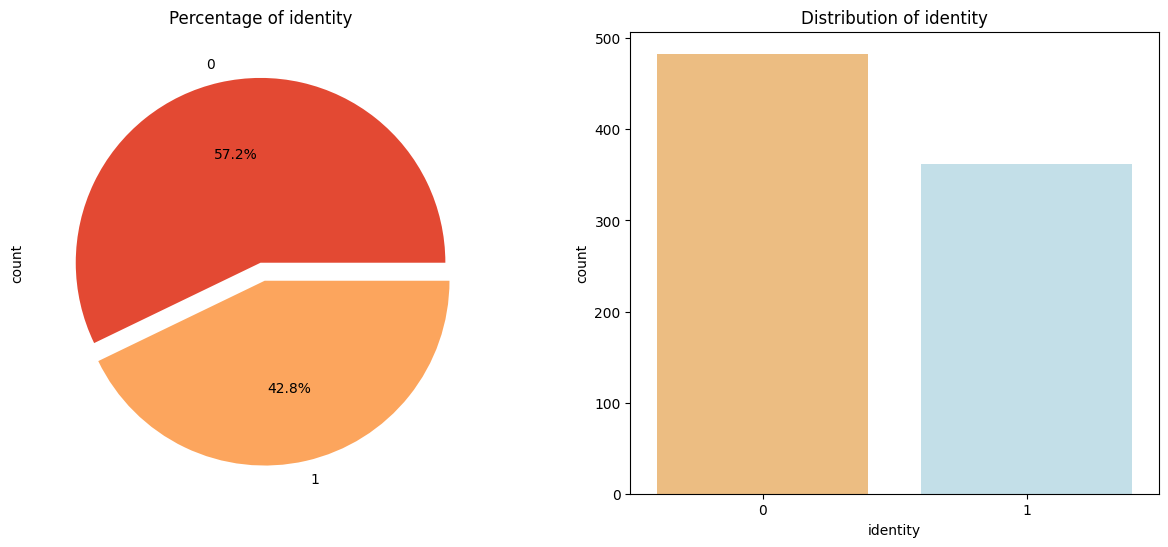

In [34]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
data_c['identity'].value_counts().plot.pie(explode=[0,0.1],colors=sns.color_palette("RdYlBu"),autopct='%1.1f%%',ax=ax1)
ax1.set_title('Percentage of identity')
sns.countplot(x='identity',data=data_c,ax=ax2,palette='RdYlBu')
ax2.set_title('Distribution of identity')
plt.show()

*Tokenizing* the dataset for use in the ANN (One_Hot Representation)

In [45]:
print('Tokenizing DF.')
tokenizer=Tokenizer(num_words=max_features,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split =' ') #filters is redundant, but still keeping if I missed any symbols previously
tokenizer.fit_on_texts(texts=data_c['text']) #fit
X=tokenizer.texts_to_sequences(texts=data_c['text'])
X=pad_sequences(sequences=X,maxlen=max_len,padding='pre') #padding the set of words
Y=data_c['identity'].values #identities (0/1)
V=tokenizer.word_index #vocabulary
print('Tokenized DF.')

Tokenizing DF.
Tokenized DF.


Creating the model and compiling it

In [46]:
def create_lstm_model(max_features): #creating the internal structure of the simple LSTM model
        print('Creating LSTM model.')
        lstm_model=Sequential(name='Sierra')
        lstm_model.add(layer=Embedding(input_dim=max_features,output_dim=128,name='Echo'))
        lstm_model.add(layer=LSTM(units=128,name='Lima'))
        lstm_model.add(layer=Dense(1,activation='sigmoid',name ='Omega'))
        print('Model creation completed.')
        lstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
        print('Model compiled.')
        return lstm_model

In [47]:
lstm_model=create_lstm_model(max_features)

Creating LSTM model.
Model creation completed.
Model compiled.


Summary of the model

In [48]:
lstm_model.summary()

Model: "Sierra"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Echo (Embedding)            (None, None, 128)         65536     
                                                                 
 Lima (LSTM)                 (None, 128)               131584    
                                                                 
 Omega (Dense)               (None, 1)                 129       
                                                                 
Total params: 197,249
Trainable params: 197,249
Non-trainable params: 0
_________________________________________________________________


Splitting the tokenized DF based on *test_prop*

In [49]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=test_prop)

Training the LSTM model

In [50]:
history=lstm_model.fit(X_train,Y_train,batch_size=batch_size,epochs=epoch_count,verbose=1,validation_split=test_prop,shuffle=1,use_multiprocessing=True)


Epoch 1/4
30/30 [==============================] - 35s 1s/step - loss: 0.6501 - accuracy: 0.6646 - val_loss: 0.5907 - val_accuracy: 0.8742
Epoch 2/4
30/30 [==============================] - 31s 1s/step - loss: 0.3435 - accuracy: 0.9156 - val_loss: 0.2461 - val_accuracy: 0.8931
Epoch 3/4
30/30 [==============================] - 32s 1s/step - loss: 0.1615 - accuracy: 0.9494 - val_loss: 0.2597 - val_accuracy: 0.8931
Epoch 4/4
30/30 [==============================] - 32s 1s/step - loss: 0.1190 - accuracy: 0.9684 - val_loss: 0.3360 - val_accuracy: 0.8868


Visualization of accuracy and loss using graph

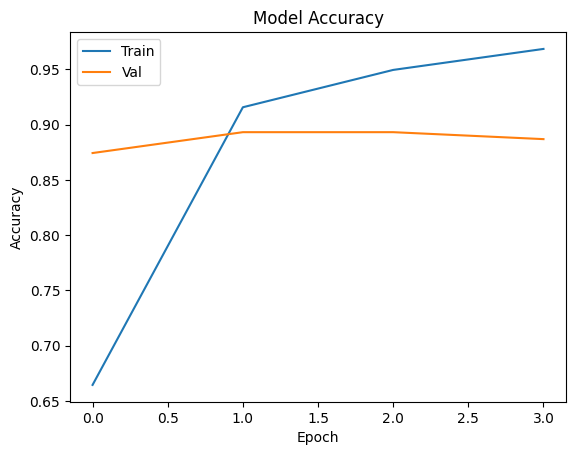

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

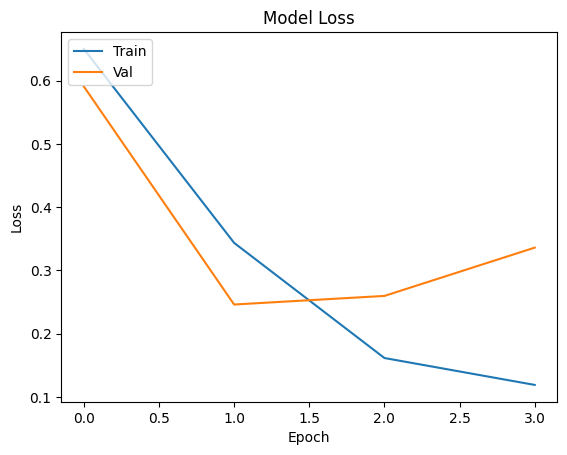

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Validation of the model

In [53]:
Y_pred=(lstm_model.predict(X_test,batch_size=batch_size,verbose=1,use_multiprocessing=True)>=0.5).astype(int)

14/14 [==============================] - 4s 295ms/step


In [54]:
accuracy_score(Y_test,Y_pred)

0.839622641509434

In [55]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       120
           1       0.79      0.86      0.82        92

    accuracy                           0.84       212
   macro avg       0.84      0.84      0.84       212
weighted avg       0.84      0.84      0.84       212



In [56]:
lstm_model.save('models/ds2-short')

INFO:tensorflow:Assets written to: models/ds2-short\assets


INFO:tensorflow:Assets written to: models/ds2-short\assets


Using *ConfusionMatrixDisplay* function to visualize the confusion matrix

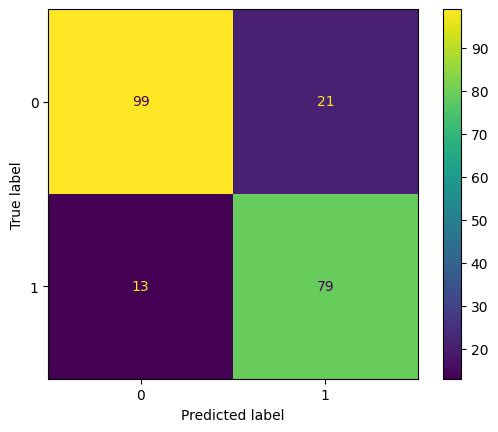

In [58]:
cm_y_pred=confusion_matrix(Y_test,Y_pred)
disp=ConfusionMatrixDisplay(cm_y_pred)
disp.plot()